## **Разработка системы анализа медицинских изображений для эпидемиологического мониторинга COVID-19**

## **Выполнил: Лапшин Степан Сергеевич**

### **1. Подготовка среды**

* **Проверка установленной Java (необходима для работы Spark)**

In [101]:
import os

# Необходимо указать путь к установленному JDK
os.environ["JAVA_HOME"] = "/usr/local/opt/openjdk@17/libexec/openjdk.jdk/Contents/Home"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

!java -version

openjdk version "17.0.17" 2025-10-21
OpenJDK Runtime Environment Homebrew (build 17.0.17+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.17+0, mixed mode, sharing)


* **Установка PySpark и необходимых библиотек**

In [102]:
!pip install -r requirements.txt -q

* **Импорт необходимых бибилиотек для выполнения работы**

In [103]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, DoubleType, StringType
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

* **Проверка работы Spark в Juputer Notebook**

In [104]:
spark = SparkSession.builder.appName("COVID19_Analysis").getOrCreate()
spark

* **Создание файла requirements.txt**

In [105]:
!pip freeze > requirements.txt

### **2. Анализ качества данных**

* **Произведем загрузку данных**

In [106]:
df = spark.read.csv("metadata.csv", header=True, inferSchema=True)
df = df.drop("_c29")
df.show(5)

+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+--------

* **Посмотрим структуру**

In [107]:
df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

* **Посмотрим основные статистики**

In [108]:
df.describe().show()

+-------+------------------+------------------+----+------------------+----------+---------------+--------+---------+------------------+--------+------+----------------------+---------+------------------+-----------------+------------------+------------------+------------------+----+--------+------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|         patientid|            offset| sex|               age|   finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|       temperature|   pO2_saturation|   leukocyte_count|  neutrophil_count|  lymphocyte_count|view|modality|              date|          location| folder|            filename|                 doi|                 url|             license|      clinical_notes|         other_notes|
+-------+------------------+------------------+----+----------------

* **Посмотрим распределение пропущенных значений по всем полям**


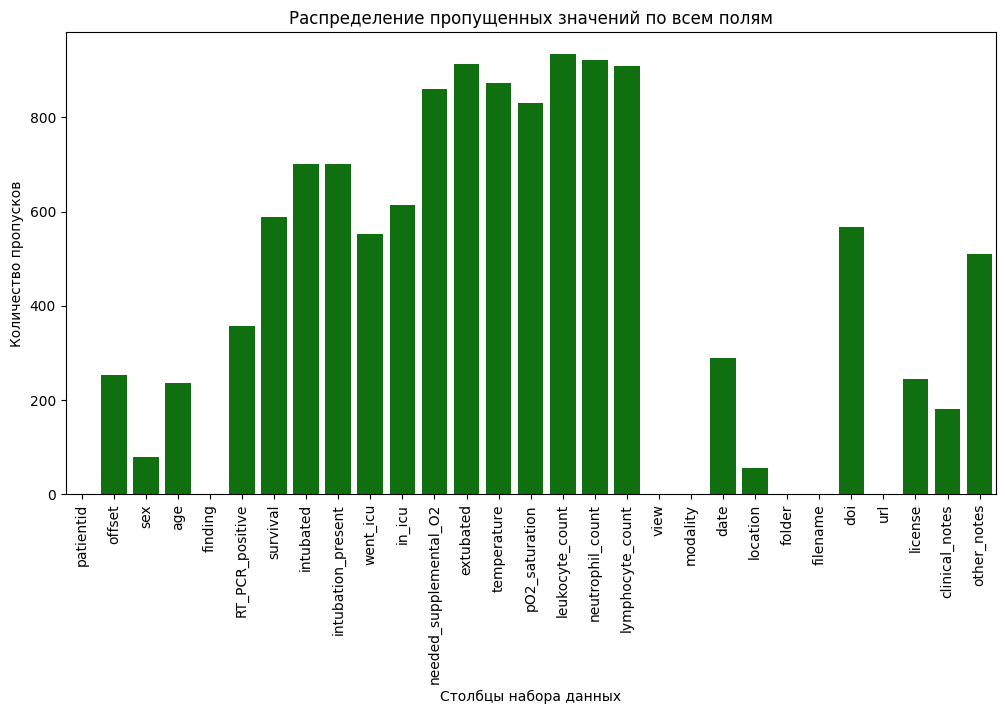

In [109]:
# Считаем количество пропусков по каждому столбцу
missing_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])

# Преобразуем в Pandas DataFrame для визуализации
missing_pd = missing_counts.toPandas().melt(var_name='column', value_name='missing_count')

# Строим график
plt.figure(figsize=(12,6))
sns.barplot(x='column', y='missing_count', color='green', data=missing_pd)
plt.xticks(rotation=90)
plt.title('Распределение пропущенных значений по всем полям')
plt.ylabel('Количество пропусков')
plt.xlabel('Столбцы набора данных')
plt.show()

> Столбцы с минимальными пропусками - **patientid, finding, view, modality, folder, filename, url**

> Столбцы с умеренным количеством пропусков - **sex (~80 пропусков), age (~237), location (~56), clinical_notes (~182)**

> Столбцы с большим количеством пропусков: **все остальные столбцы (количество пропусков от 300 до 900)**

* **Выявим и обработаем аномальные значения**

In [110]:
# Будем использовать метод межквартильного размаха

# Создадим пустой список для колонок с аномалиями
numeric_cols_filtered = []

# Определяем числовые колонки
numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]

# Запускаем цикл по числовым колонкам
for c in numeric_cols:
    # Вычисляем квартили и IQR
    Q1, Q3 = df.approxQuantile(c, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1

    # Вычисляем границы
    lower_bound = round(Q1 - 1.5 * IQR, 2)
    upper_bound = round(Q3 + 1.5 * IQR, 2)
    print(f"{c}: lower={lower_bound}, upper={upper_bound}")
    
    # Количество аномальных значений
    outliers = df.filter((F.col(c) < lower_bound) | (F.col(c) > upper_bound))
    print(f"Количество аномальных значений в поле {c}: {outliers.count()}\n")

    if outliers.count() > 0:
        numeric_cols_filtered.append(c)


offset: lower=-15.0, upper=25.0
Количество аномальных значений в поле offset: 72

age: lower=2.5, upper=102.5
Количество аномальных значений в поле age: 0

temperature: lower=36.35, upper=39.95
Количество аномальных значений в поле temperature: 6

pO2_saturation: lower=-27.0, upper=165.0
Количество аномальных значений в поле pO2_saturation: 3

leukocyte_count: lower=-2.48, upper=11.73
Количество аномальных значений в поле leukocyte_count: 0

neutrophil_count: lower=-3.5, upper=12.5
Количество аномальных значений в поле neutrophil_count: 1

lymphocyte_count: lower=-0.52, upper=2.55
Количество аномальных значений в поле lymphocyte_count: 5



Аномалии буду обработывать заменой на границы, что сохраняет все строки набора данных

В тоже время снижает влияние выбросов и одновременно сохраняет редкие, но реальные значения

In [111]:
# Заменим все аномалии на границы
for c in numeric_cols_filtered:
    Q1, Q3 = df.approxQuantile(c, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1
    
    # Вычисляем границы
    lower_bound = round(Q1 - 1.5 * IQR, 2)
    upper_bound = round(Q3 + 1.5 * IQR, 2)
    
    # Считаем количество аномалий ДО замены
    outlier_count = df.filter((F.col(c) < lower_bound) | (F.col(c) > upper_bound)).count()
    
    print(f"\nПоле: {c}")
    print(f"  Аномалий до обработки: {outlier_count}")
    
    # Замена значений на граничныфе
    df = df.withColumn(c,
        F.when(F.col(c) < lower_bound, lower_bound)
        .when(F.col(c) > upper_bound, upper_bound)
        .otherwise(F.col(c))
    )
    
    # Проверяем количество аномалий ПОСЛЕ обработки
    after_count = df.filter((F.col(c) < lower_bound) | (F.col(c) > upper_bound)).count()
    print(f"  Аномалий после обработки: {after_count}")


Поле: offset
  Аномалий до обработки: 72
  Аномалий после обработки: 0

Поле: temperature
  Аномалий до обработки: 6
  Аномалий после обработки: 0

Поле: pO2_saturation
  Аномалий до обработки: 3
  Аномалий после обработки: 0

Поле: neutrophil_count
  Аномалий до обработки: 1
  Аномалий после обработки: 0

Поле: lymphocyte_count
  Аномалий до обработки: 5
  Аномалий после обработки: 0


* **Задокументируем обнаруженные проблемы данных**

1. Самая главная проблема данных - большое количество пропусков

> Анализ пропущенных значений показал, что существенная часть полей содержит значительное число пропусков (от 300 до 900 значений), что типично для медицинских датасетов, где сбор данных происходит неравномерно. Такое распределение пропусков указывает на неполноту информации и необходимость дальнейших мер по работе с отсутствующими значениями.

2. Наличие аномальных значений в числовых полях

> Для всех числовых полей был рассчитан межквартильный размах (IQR), на основе которого выделены выбросы. Несколько колонок содержали значения, выходящие за границы допустимого диапазона. Все найденные аномальные значения были приведены к границам IQR, что позволило сохранить записи и одновременно снизить искажение статистики

### **3. Предобработка данных**

* **В самом начале обработаем колонку date**

Необходимо преобразовать формат, заполнить того, чего нет

In [ ]:
# Очистка даты: убираем пробелы, неразрывные пробелы и точки в конце
df = df.withColumn(
    "date_clean",
    F.trim(F.regexp_replace(F.col("date").cast("string"), r"[\u00A0\.]+$", " ")))

# ваш логический блок почти без изменений — использую date_clean и поменял местами MMM и MMMM проверки
df = df.withColumn(
    "date",
    # Если есть только год (2020)
    F.when(F.col("date_clean").rlike(r"^\d{4}$"), F.to_date(F.col("date_clean"), "yyyy"))

    # Если есть полная дата формат 1 (1/13/2020)
    .when(F.col("date_clean").rlike(r"^\d{1,2}/\d{1,2}/\d{4}$"), F.to_date(F.col("date_clean"), "M/d/yyyy"))
    
    # Если есть полная дата формат 2 (01/13/20)
    .when(F.col("date_clean").rlike(r"^\d{1,2}/\d{1,2}/\d{2}$"), F.to_date(F.col("date_clean"), "MM/dd/yy"))

    # !!! Сначала проверяем сокращённое название месяца (Jan, Feb, Oct и т.п.)
    .when(F.col("date_clean").rlike(r"^[A-Za-z]{3} \d{1,2}, \d{4}$"), F.to_date(F.col("date_clean"), "MMM d, yyyy"))

    # После — полное название месяца (January 13, 2020)
    .when(F.col("date_clean").rlike(r"^[A-Za-z]+ \d{1,2}, \d{4}$"), F.to_date(F.col("date_clean"), "MMMM d, yyyy"))

    # Если есть только месяц и год (January 2020)
    .when(F.col("date_clean").rlike(r"^[A-Za-z]+ \d{4}$"), F.to_date(F.col("date_clean"), "MMMM yyyy"))

    # Если есть месяц и день (January 13)
    .when(F.col("date_clean").rlike(r"^[A-Za-z]+ \d{1,2}$"), F.to_date(F.concat(F.col("date_clean"), F.lit(" 2020")), "MMMM d yyyy"))

    # Если ничего нет заменяем на None
    .otherwise(F.lit(None).cast("date"))  
).drop("date_clean")

Будем использовать среднюю дату для заполнения пропусков

Потому что она представляет собой нейтральное центральное значение распределения и минимально искажает общую временную динамику данных

Такой подход предотвращает смещение выборки вперёд или назад во времени, которое возникло бы при использовании крайних значений или случайных дат

In [113]:
# Вычисляем среднюю дату среди всех НЕ-null значений
avg_ts = (df.select(F.avg(F.col("date").cast("timestamp").cast("long")).alias("avg_ts")).collect()[0]["avg_ts"])

# Превращаем среднее значение в дату
avg_date = F.from_unixtime(F.lit(avg_ts)).cast("date")

# Заполняем NULL средней датой
df = df.withColumn("date",F.when(F.col("date").isNull(), avg_date).otherwise(F.col("date")))

* **Обработка пропусков**

По условию задачи сказано "Для числовых полей использовать статистические методы заполнения"

Значит необходимо заполнить значениями, полученными из самих полей

In [114]:
# Заполняем все числовые поля средним значением
for c in numeric_cols:
    # Количество пропусков до заполнения
    missing_before = df.filter(F.col(c).isNull()).count()

    # Считаем среднее и заполняем
    avg_value = df.select(F.mean(c)).first()[0]
    df = df.fillna({c: round(avg_value, 2)})

    # Количество пропусков после заполнения
    missing_after = df.filter(F.col(c).isNull()).count()

    print(f"Числовое поле: {c}")
    print(f"  Пропусков до заполнения: {missing_before}")
    print(f"  Пропусков после заполнения: {missing_after}\n")

Числовое поле: offset
  Пропусков до заполнения: 253
  Пропусков после заполнения: 0

Числовое поле: age
  Пропусков до заполнения: 237
  Пропусков после заполнения: 0

Числовое поле: temperature
  Пропусков до заполнения: 872
  Пропусков после заполнения: 0

Числовое поле: pO2_saturation
  Пропусков до заполнения: 831
  Пропусков после заполнения: 0

Числовое поле: leukocyte_count
  Пропусков до заполнения: 934
  Пропусков после заполнения: 0

Числовое поле: neutrophil_count
  Пропусков до заполнения: 922
  Пропусков после заполнения: 0

Числовое поле: lymphocyte_count
  Пропусков до заполнения: 910
  Пропусков после заполнения: 0



По условию задачи сказано "Для категориальных данных применять стратегии на основе частотности"

Значит необходимо заполнить значениями, которые наиболее часто встречаются (модой)

In [115]:
# Определяем колонки категореальные
categorical_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, StringType) and field.name not in numeric_cols]

for c in categorical_cols:
    # Количество пропусков до заполнения
    missing_before = df.filter(F.col(c).isNull()).count()

    if missing_before == 0:
        continue

    # Находим наиболее частое значение (моду) и заполняем
    mode_value = df.filter(F.col(c).isNotNull()) \
               .groupBy(c) \
               .count() \
               .orderBy('count', ascending=False) \
               .first()[0]
    df = df.fillna({c: mode_value})

    # Количество пропусков после заполнения
    missing_after = df.filter(F.col(c).isNull()).count()

    print(f"Категориальная колонка: {c}")
    print(f"Выбранное значение: {mode_value}")
    print(f"  Пропусков до заполнения: {missing_before}")
    print(f"  Пропусков после заполнения: {missing_after}\n")

Категориальная колонка: sex
Выбранное значение: M
  Пропусков до заполнения: 80
  Пропусков после заполнения: 0

Категориальная колонка: RT_PCR_positive
Выбранное значение: Y
  Пропусков до заполнения: 357
  Пропусков после заполнения: 0

Категориальная колонка: survival
Выбранное значение: Y
  Пропусков до заполнения: 589
  Пропусков после заполнения: 0

Категориальная колонка: intubated
Выбранное значение: Y
  Пропусков до заполнения: 702
  Пропусков после заполнения: 0

Категориальная колонка: intubation_present
Выбранное значение: N
  Пропусков до заполнения: 700
  Пропусков после заполнения: 0

Категориальная колонка: went_icu
Выбранное значение: Y
  Пропусков до заполнения: 553
  Пропусков после заполнения: 0

Категориальная колонка: in_icu
Выбранное значение: N
  Пропусков до заполнения: 615
  Пропусков после заполнения: 0

Категориальная колонка: needed_supplemental_O2
Выбранное значение: Y
  Пропусков до заполнения: 860
  Пропусков после заполнения: 0

Категориальная колонка: 

* **Необходимо унифицировать диагнозы (с использование UDF)**

Это значит, что для одних и техже диагназов написанных по-разному нужна одна и таже категория

In [116]:
# Функция унификации
def unify_finding(finding):
    if finding is None:
        return "Other"
    f = finding.strip().lower()
    if "covid" in f:
        return "COVID-19"
    elif "pneumonia" in f:
        return "Pneumonia"
    elif "tuberculosis" in f:
        return "Tuberculosis"
    else:
        # К этой группе относим todo, Unknown, No Finding и прочее
        return "Other"

In [117]:
# Регистрируем UDF
unify_finding_udf = F.udf(unify_finding, StringType())

# Применяем UDF к колонке
df = df.withColumn("finding", unify_finding_udf(F.col("finding")))

# Проверим результат
df.select("finding").distinct().show(truncate=False)

+------------+
|finding     |
+------------+
|Tuberculosis|
|Other       |
|COVID-19    |
|Pneumonia   |
+------------+



* **Удалим дубликаты**

In [118]:
# Считаем количество строк до удаления дубликатов
print(f"Количество строк до удаления дубликатов: {df.count()}")

# Удаляем полностью идентичные строки
df = df.dropDuplicates()

# Считаем количество строк после
print(f"Количество строк после удаления дубликатов: {df.count()}")

Количество строк до удаления дубликатов: 950
Количество строк после удаления дубликатов: 950


Полных дубликатов строк нет

> **Поэтому дубликаты в данных определим, как записи с одинаковыми patientid и offset**

> **Логика заключается в том, что каждая запись с конкретным offset отражает уникальное наблюдение пациента**

> **Повторные строки с теми же значениями не содержат новой информации и должны быть удалены для обеспечения корректности анализа**

In [119]:
# Создаем окно для patientid + offset
window = Window.partitionBy("patientid", "offset").orderBy("offset")

# Добавляем номер строки в окне
df = df.withColumn("row_num", F.row_number().over(window))

# Считаем количество дубликатов (строки с row_num > 1)
duplicates_count = df.filter(F.col("row_num") > 1).count()
print(f"Найдено и удалено дубликатов: {duplicates_count}")

# Удаляем дубликаты, оставляя только первую запись для каждого patientid + offset
df = df.filter(F.col("row_num") == 1).drop("row_num")

Найдено и удалено дубликатов: 199


### **4. SQL-аналитика**

In [120]:
# Для SQL-запросов создаем временную таблицу
df.createOrReplaceTempView("help_table")

* **Запрос 1. Базовая статистика по диагнозам**

> Группируем записи по **finding**

> Считаем общее количество - **COUNT(*)**

> Считаем уникальное количество пациентов - **COUNT(DISTINCT patientid)**

> Сортируем

In [121]:
spark.sql("""
    SELECT
        finding AS `Диагноз`,
        COUNT(*) AS `Общее количество записей`,
        COUNT(DISTINCT patientid) AS `Количество уникальных пациентов`
    FROM help_table
    GROUP BY finding
    ORDER BY `Общее количество записей` DESC
""").show(truncate=False)

+------------+------------------------+-------------------------------+
|Диагноз     |Общее количество записей|Количество уникальных пациентов|
+------------+------------------------+-------------------------------+
|COVID-19    |482                     |319                            |
|Pneumonia   |170                     |114                            |
|Other       |88                      |43                             |
|Tuberculosis|11                      |11                             |
+------------+------------------------+-------------------------------+



Оптимизация:
> groupBy + агрегатные функции эффективны в Spark

> countDistinct выполняется параллельно

> Выбираем только нужные колонки "finding", "patientid", чтобы уменьшить нагрузку

* **Запрос 2. Распределение по полу и диагнозам**

> Группируем по sex и finding

> Считаем количетсво зпаисей в каждой группе - **COUNT(*)**

> Сортируем

In [122]:
spark.sql("""
    SELECT
        sex AS `Пол`,
        finding AS `Диагноз`,
        COUNT(*) AS `Количество больных`
    FROM help_table
    GROUP BY sex, finding
    ORDER BY finding, sex
""").show(truncate=False)

+---+------------+------------------+
|Пол|Диагноз     |Количество больных|
+---+------------+------------------+
|F  |COVID-19    |152               |
|M  |COVID-19    |330               |
|F  |Other       |29                |
|M  |Other       |59                |
|F  |Pneumonia   |73                |
|M  |Pneumonia   |97                |
|F  |Tuberculosis|3                 |
|M  |Tuberculosis|8                 |
+---+------------+------------------+



Оптимизация:

> Прямой groupBy без JOIN и сложных вычислений

> Можно добавить кэширование при необходимости

* **Запрос 3. Оконная функция (топ-3 по возрасту в каждой группе диагнозов)**

> Используем окно **PARTITION BY finding** для разделения данных по диагнозу

> Сортируем по возрасту внутри группы - **ORDER BY age DESC**

> Присваиваем каждой строке номер в пределах окна - **ROW_NUMBER()**

> Выбираем первые 3 строки для каждой группы - **rank <= 3**

In [123]:
spark.sql("""
    SELECT finding  AS `Диагноз`, 
           age  AS `Возраст`, 
           sex  AS `Пол`, 
           rank  AS `Топ`
    FROM (
        SELECT
            finding,
            age,
            sex,
            ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) AS rank
        FROM help_table
    ) sub
    WHERE rank <= 3
    ORDER BY finding, rank
""").show(truncate=False)

+------------+-------+---+---+
|Диагноз     |Возраст|Пол|Топ|
+------------+-------+---+---+
|COVID-19    |94     |M  |1  |
|COVID-19    |93     |F  |2  |
|COVID-19    |93     |F  |3  |
|Other       |78     |F  |1  |
|Other       |75     |M  |2  |
|Other       |70     |F  |3  |
|Pneumonia   |90     |M  |1  |
|Pneumonia   |80     |M  |2  |
|Pneumonia   |80     |F  |3  |
|Tuberculosis|78     |M  |1  |
|Tuberculosis|70     |M  |2  |
|Tuberculosis|58     |M  |3  |
+------------+-------+---+---+



Оптимизация:

> ROW_NUMBER() эффективно ранжирует строки без необходимости сортировки всего набора данных

> Фильтр на rank <= 3 уменьшает размер итогового результата, что снижает нагрузку на дальнейшие вычисления

* **Запрос 4. Анализ временных трендов по датам исследований**

> Берём все строки с диагнозами и датами - **finding, YEAR(date), MONTH(date)**

> Группируем по диагнозу и периоду, чтобы понять динамику во времени - **(YEAR(date), MONTH(date))**

> Считаем количество исследований за каждый месяц для каждого диагноза - **COUNT(*)**

> Сортируем

In [124]:
spark.sql("""
    SELECT
        finding AS `Диагноз`,
        YEAR(date) AS `Год`,
        MONTH(date) AS `Месяц`,
        COUNT(*) AS `Количество исследований`
    FROM help_table
    GROUP BY finding, YEAR(date), MONTH(date)
    ORDER BY finding, `Год`, `Месяц`
""").show(100, truncate=False)

+------------+----+-----+-----------------------+
|Диагноз     |Год |Месяц|Количество исследований|
+------------+----+-----+-----------------------+
|COVID-19    |2018|11   |93                     |
|COVID-19    |2019|12   |4                      |
|COVID-19    |2020|1    |347                    |
|COVID-19    |2020|2    |14                     |
|COVID-19    |2020|3    |23                     |
|COVID-19    |2020|4    |1                      |
|Other       |2018|11   |10                     |
|Other       |2019|1    |1                      |
|Other       |2020|1    |76                     |
|Other       |2020|3    |1                      |
|Pneumonia   |2003|3    |5                      |
|Pneumonia   |2004|1    |10                     |
|Pneumonia   |2007|1    |1                      |
|Pneumonia   |2009|9    |3                      |
|Pneumonia   |2010|1    |2                      |
|Pneumonia   |2010|5    |1                      |
|Pneumonia   |2010|10   |1                      |


Оптимизация:

> Группировка выполняется эффективно, агрегаты минимизируют нагрузку

> Результат можно сразу использовать для построения графика временного тренда

* **Запрос 5. Статистика по проекциям снимков и их связи с диагнозами**

> Группируем по finding и view

> Считаем количество записей в каждой комбинации с помощью **COUNT(*)**

> Сортируем сначала по finding, затем по view

In [125]:
spark.sql("""
    SELECT
        finding AS `Диагноз`,
        view AS `Проекция снимка`,
        COUNT(*) AS `Количество`
    FROM help_table
    GROUP BY finding, view
    ORDER BY finding, view
""").show(truncate=False)

+------------+---------------+----------+
|Диагноз     |Проекция снимка|Количество|
+------------+---------------+----------+
|COVID-19    |AP             |126       |
|COVID-19    |AP Supine      |127       |
|COVID-19    |Axial          |37        |
|COVID-19    |Coronal        |3         |
|COVID-19    |L              |10        |
|COVID-19    |PA             |179       |
|Other       |AP             |3         |
|Other       |AP Supine      |61        |
|Other       |Axial          |4         |
|Other       |PA             |20        |
|Pneumonia   |AP             |39        |
|Pneumonia   |AP Erect       |1         |
|Pneumonia   |AP Supine      |21        |
|Pneumonia   |L              |26        |
|Pneumonia   |PA             |83        |
|Tuberculosis|AP             |2         |
|Tuberculosis|L              |1         |
|Tuberculosis|PA             |8         |
+------------+---------------+----------+



Оптимизация:

> Простое агрегирование без JOIN

> Можно использовать cache() на df для повторного использования

> Выбираем только нужные колонки (finding, view), чтобы уменьшить передачу данных между узлами и нагрузку на память

### **5. Обработка в PySpark**

Базовая обработка в виде фильтрации данных по заднным критерия производилась ранее (на протяжении всего **"3. Предобработка данных"**)

Унификация диагназов уже сделана (в **"3. Предобработка данных"**), так как требовалась для формирования запросов SQL

* **Реализация пользовательской функции для категоризации возраста (с использованием UDF)**

In [126]:
# Сама функция
def age_category(age):
    if age < 18:
        return "Ребенок"
    elif age < 40:
        return "Взрослый"
    elif age < 60:
        return "Средний возраст"
    else:
        return "Пожилой"

# Создаем UDF
age_category_udf = F.udf(age_category, StringType())

# Применяем к DataFrame
df = df.withColumn("Возрастная категория", age_category_udf(F.col("age")))

* **Базовая обработка - Сохранение результатов в оптимизированном формате**

> Для хранения обработанных данных используется формат Parquet, так как он является колонко-ориентированным и обеспечивает эффективное сжатие и быстрый доступ к данным. 

> Сохранение в Parquet позволяет легко работать с большими наборами данных, ускоряет чтение нужных колонок и снижает нагрузку на вычислительные ресурсы

> Кроме того, Parquet поддерживает интеграцию с PySpark и другими инструментами аналитики, что удобно для дальнейшей обработки, построения графиков и машинного обучения

> Такой подход обеспечивает долговременное и структурированное хранение результатов анализа



In [127]:
# Сохраняем результат в Parquet
df.write.mode("overwrite").parquet("parquet")

### **6. Визуализация**

Для наглядного анализа распределения и динамики исследований были построены визуализации на основе сохранённых файлов Parquet 

Графики позволяют оценить распределение диагнозов, возрастные группы пациентов, временные тренды исследований и зависимость диагнозов от проекций снимков

In [128]:
# Читаем Parquet в PySpark
df = spark.read.parquet("parquet")

# Конвертируем в Pandas для визуализации
df_pd = df.toPandas()

* **Круговая диаграмма распределения диагнозов**

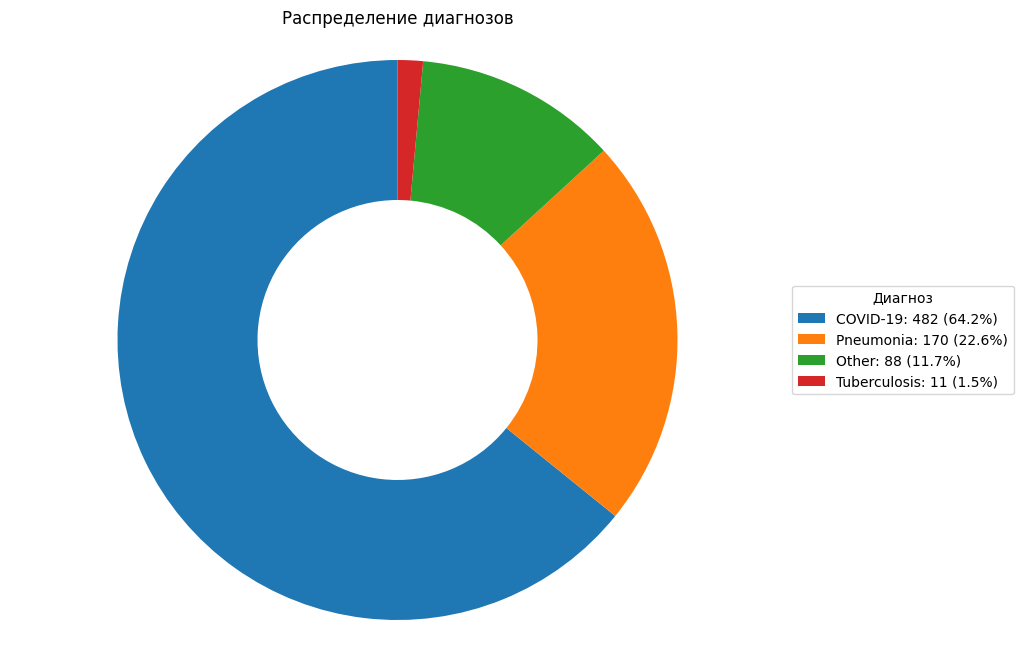

In [129]:
finding_counts = df_pd['finding'].value_counts()

# Создаем фигуру
plt.figure(figsize=(10, 8))
wedges, texts = plt.pie(finding_counts, startangle=90, wedgeprops=dict(width=0.5))

# Добавляем легенду
percentages = finding_counts / finding_counts.sum() * 100
labels = [f"{label}: {count} ({percent:.1f}%)" for label, count, percent in zip(finding_counts.index, finding_counts.values, percentages)]
plt.legend(wedges, labels, title="Диагноз", bbox_to_anchor=(1, 0.5), loc="center left")

plt.title('Распределение диагнозов')
plt.axis('equal')
plt.show()

* **Столбчатая диаграмма по возрастным группам**

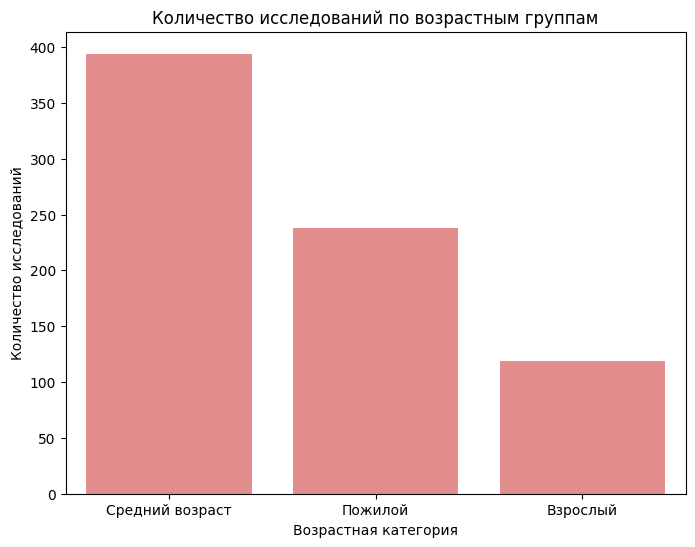

In [130]:
age_group_df = df_pd['Возрастная категория'].value_counts().reset_index()
age_group_df.columns = ['Возрастная категория', 'Количество']

plt.figure(figsize=(8, 6))
sns.barplot(
    data=age_group_df,
    x='Возрастная категория',
    y='Количество',
    color="lightcoral"
)
plt.title('Количество исследований по возрастным группам')
plt.xlabel('Возрастная категория')
plt.ylabel('Количество исследований')
plt.show()

* **График временных трендов исследований**

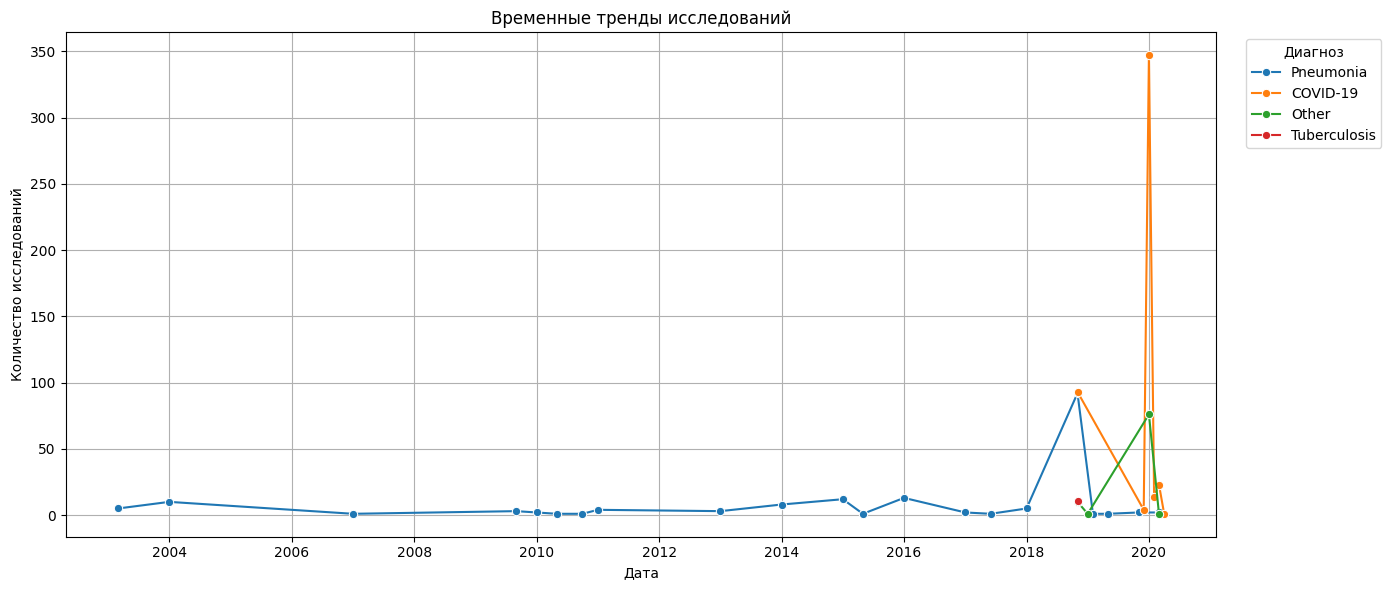

In [131]:
# Группируем по месяцам и подсчитываем количество исследований
df_pd['date'] = pd.to_datetime(df_pd['date'], errors='coerce')
df_trend = df_pd.groupby([df_pd['date'].dt.to_period('M'), 'finding']).size().reset_index(name='Количество исследований')
df_trend['Дата'] = df_trend['date'].dt.to_timestamp()

# Строим график с разделением по диагнозам
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_trend, x='Дата', y='Количество исследований', hue='finding', marker='o', palette='tab10')

plt.title('Временные тренды исследований')
plt.xlabel('Дата')
plt.ylabel('Количество исследований')
plt.legend(title='Диагноз', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

* **Heatmap распределения диагнозов по проекциям снимков**

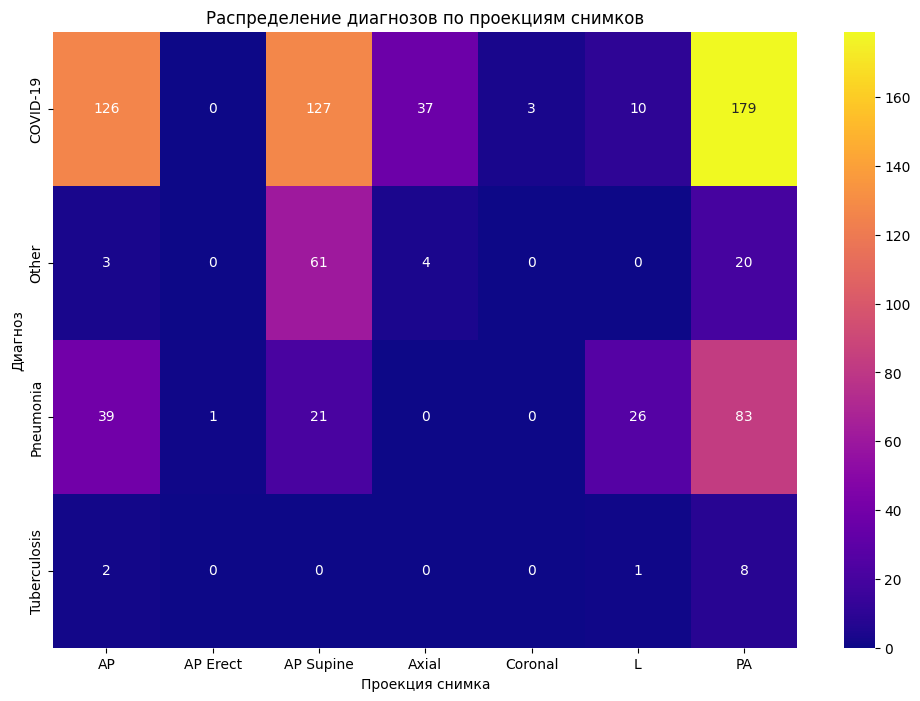

In [132]:
heatmap_data = df_pd.pivot_table(
    index='finding',
    columns='view',
    values='age',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="plasma")
plt.title('Распределение диагнозов по проекциям снимков')
plt.xlabel('Проекция снимка')
plt.ylabel('Диагноз')
plt.show()

### **7. Вывод по работе**

В ходе выполнения проекта была проведена комплексная предобработка метаданных рентгеновских снимков пациентов с различными диагнозами, включая **COVID-19**, **пневмонию** и **туберкулёз**. Основные этапы работы включали:

* Очистку данных и удаление дубликатов
* Унификацию диагнозов
* Заполнение пропусков в числовых и категориальных полях с использованием статистических методов
* Создание возрастных категорий и подготовку данных для аналитики

### Основные результаты анализа

* Среди пациентов с **COVID-19** преобладают люди среднего и пожилого возраста
* Временные тренды исследований выявили **резкие эпидемиологические пики в 2020 году**, отражающие начало пандемии, с дополнительными сезонными колебаниями
* По проекциям снимков для COVID-19 преобладают PA и AP (включая AP Supine)
* Многие клинические данные сильно неполные (имеют **пропуски и аномалии**), что типично для медицинских датасетов. Статистические методы заполнения и обработка выбросов позволили сохранить репрезентативность данных

### Рекомендации по улучшению системы

1. Внедрение **строгой валидации данных** на этапе их сбора для снижения количества пропусков и аномалий
2. Автоматизация процесса **унификации диагнозов и категорий** для ускорения аналитики
3. Регулярное **обновление и расширение базы данных** для повышения точности эпидемиологического мониторинга
4. Использование **дополнительных источников данных** для более комплексного анализа

### Итог

Проект является итоговой работой по дисциплине «Инфраструктура Big Data» и позволяет применить на практике полученные знания о распределённых вычислениях и работе с PySpark

В рамках выполнения проекта я изучил на практике использование SQL в Spark, работу с оконными функциями, методы аналитической обработки данных и построение визуализаций

Работа проводилась на реальном медицинском датасете, что позволило решать задачи, близкие к профессиональной практике анализа данных

В ходе проекта осуществлялась подготовка данных, их очистка и унификация, выполнение аналитических запросов, а также визуализация результатов, что формирует навыки полноценного цикла работы с Big Data